## SQL with Pandas

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import sqlalchemy as sqla
import sqlite3
##????????
%matplotlib inline  
plt.style.use('ggplot')

Let's create a reader object, which will make it so that we can read the csv in chunks.  When we specify the chunksize this indicates that we want an iterator that will reach these chunks into memory.

In [2]:
nycjobs_reader = pd.read_csv('jobs.csv',
                             chunksize=10000,low_memory=False,encoding='latin-1')

In [10]:
nyc_conn

Engine(sqlite:///../data/nycjobs.sqlite)

In [3]:
nycjobs_chunk = nycjobs_reader.next()
nyc_cols = nycjobs_chunk.columns

Let's create the sqlite file, and create the connection.

In [14]:
sqlite_file = './data/nycjobs.sqlite'
nyc_conn = sqla.create_engine('sqlite:///' + sqlite_file)

The following code will create the table jobs and fill it in.

In [15]:
nycjobs_chunk.to_sql('jobs',nyc_conn,if_exists='replace')
for nycjobs_chunk in nycjobs_reader:
    nycjobs_chunk.to_sql('jobs',nyc_conn,if_exists='append')

Now, we get to make our first query.  Let's count the number of records in the jobs table.  We can also count the number of plumbing jobs.

In [16]:
pd.read_sql_query("select count(*) from jobs",nyc_conn)

,count(*)
0,90000


In [17]:
pd.read_sql_query("select count(*) from jobs where Plumbing='X'",nyc_conn)

,count(*)
0,28258


In [18]:
pd.read_sql_query("select Plumbing, count(*) as count from jobs group by Plumbing",nyc_conn)

,Plumbing,count
0,None,22405
1,,39337
2,X,28258


We can also order these by the initial cost in descending order.

In [19]:
sql_query = """
select * from jobs 
where Plumbing='X' 
order by "Initial Cost" desc
"""
plumbing = pd.read_sql_query(sql_query,nyc_conn)

In [20]:
plumbing.head()

,index,Unnamed: 0,Job #,Doc #,Borough,House #,Street Name,Block,Lot,Bin #,...,Owner's Last Name,Owner's Business Name,Owner's House Number,Owner'sHouse Street Name,City,State,Zip,Owner'sPhone #,Job Description,DOBRunDate
0,12800,12800,320771198,1,BROOKLYN,68,GRAND STREET,2390,23,3062758,...,DENNIS,N/A,68,GRAND STREET,BROOKLYN,NY,11249,7185992245,INTERIOR RENOVATION OF AN EXISTING 3 STORY PLU...,06/13/2013 12:00:00 AM
1,97519,97519,122059084,1,MANHATTAN,160,WEST 66TH ST,1137,7501,1077844,...,LO,None,160,WEST 66TH ST,NY,NY,10023,2154785182,RENOVATION AND COMBINATION OF APTS 22G AND 22H...,07/08/2014 12:00:00 AM
2,89083,89083,340146498,1,BROOKLYN,134,AMITY STREET,296,17,3003125,...,HORNBECK,None,134,AMITY STREET,BROOKLYN,NY,11201,9178594901,PROPOSED INTERIOR RENOVATION TO MERGE EXISTING...,05/21/2014 12:00:00 AM
3,25690,25690,420874405,1,QUEENS,102-21,CORONA AVENUE,1983,66,4048758,...,RAYMOND,N/A,102-21,CORONA AVENUE,QUEENS,NY,11368,9174025031,CONVERT EXISTING 2 FAMILY DWELLING TO 3 FAMILY...,07/31/2013 12:00:00 AM
4,94952,94952,122017389,1,MANHATTAN,251,EAST 51 STREET,1325,24,1038472,...,BAKER,251 E 51 STREET CORP.,251,E 51 STREET,NEW YORK,NY,10022,4062201100,INTERIOR RENOVATION OF APT. 17C. MINOR NON BEA...,06/25/2014 12:00:00 AM


Now, let's look at the "group by" clause, which will count the number of postings for each owner business name.

In [26]:
query = """select "Owner's Business Name", count(*) as count from jobs 
    where "Owner's Business Name"!=" " 
    group by "Owner's Business Name" """
owner_counts = pd.read_sql_query(query,nyc_conn)

In [22]:
owner_counts.head()

,Owner's Business Name,count
0,20 EAST 35 STREET OWNERS CORP,1
1,30 WEST 76TH ST REALTY LLC,2
2,40 FLATBUSH REALTY ASSOCIATES,1
3,BRONXWOOD HOME FOR THE AGED IN,1
4,CHELSEA REALTY GROUP LLC,1


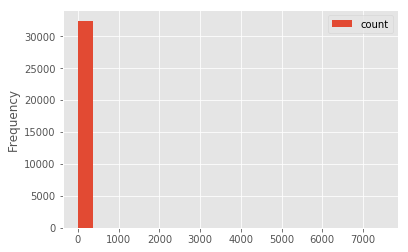

In [23]:
_ = owner_counts.plot.hist("count",bins=20)

Good thing we looked at this, there seem to be lots of outliers here, and so there are a few businesses with many postings.

In [24]:
(owner_counts['count'] > 1000).sum()

1

In [27]:
owner_counts[owner_counts['count'] > 1000]

,Owner's Business Name,count
23315,N/A,7474


So, we need to worry about the other encodings of NAs and the rest of these seem to be large organizations.

## sqlite3 package
Now, let's use the sqlite3 package to make more sql statements other than the select queries.  We will create a table of owners, and then make a join with the jobs table to demonstrate join.

In [28]:
conn3 = sqlite3.connect(sqlite_file) #sqlite_file is just a path: sqlite_file = './data/nycjobs.sqlite'

In [29]:
c = conn3.cursor() # ????

In [30]:
c.execute("""create table owner as
    select "Owner's Last Name", "Owner's First Name", 
    "Owner's Business Name", "Owner's House Number", "Owner'sPhone #",
    count(*) from jobs group by "Owner's Business Name" """)

In [31]:
c.execute("""select *, count(*) from owner""")
c.fetchone() # get the value???

(u'JACOB                         ',
 u'YUVAL          ',
 u'ZYP, INC.                       ',
 u'167-10      ',
 7185410223L,
 3,
 32454)

In [32]:
c.execute("""select * from jobs left join owner 
    on "jobs.Owner's Business Name"="owner.Owner's Business Name" """)
c.fetchone()

(10000,
 10000,
 420851536,
 1,
 u'QUEENS',
 u'118-15      ',
 u'150 AVENUE                      ',
 11819,
 1,
 4256899,
 u'A2',
 u'D',
 u'APPLICATION PROCESSED - ENTIRE          ',
 u'05/31/2013',
 u'1-2-3 FAMILY',
 u'410',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 u'Y',
 u' ',
 u' ',
 u' ',
 u' ',
 u' ',
 u' ',
 u' ',
 u' ',
 u'X',
 u' ',
 u' ',
 u'X',
 u'PARTIAL DEMO   ',
 u'RUSSELL        ',
 u'DANCE 111                     ',
 u'PE',
 u'0085457',
 u'Y',
 u'05/31/2013',
 u'05/31/2013',
 u'05/31/2013',
 None,
 None,
 None,
 u'$14220.00',
 u'$341.50',
 u'STANDARD',
 0,
 0,
 None,
 None,
 0,
 0,
 2,
 2,
 25,
 25,
 u'    2',
 u'    2',
 u'J-3 ',
 u'J-3 ',
 u'NOT APPLICABLE                          ',
 u'R3-2        ',
 None,
 None,
 None,
 None,
 None,
 None,
 u'RAMCHAN        ',
 u'SUKHOO                        ',
 u'N/A                             ',
 u'103-36      ',
 u'106 STREET                      ',
 u'QUEENS         ',
 u'NY',
 11417,
 6468318950L,
 u"PROPOSED PARTIAL